In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/happy-house-dataset/train_happy.h5
/kaggle/input/happy-house-dataset/test_happy.h5


Our goal is to build a Convolutional Neural Network that can be applied. Let's start with something simple. We are going to use the "Happy House Dataset", it's a dataset of images of people, who might be happy (smiling) or not so happy (not smiling :( ) 
So it's a binary classification.

Now we import the dataset.

In [2]:
import h5py

In [3]:
train_dataset = h5py.File("/kaggle/input/happy-house-dataset/train_happy.h5", "r")
test_dataset = h5py.File("/kaggle/input/happy-house-dataset/test_happy.h5", "r")
print(train_dataset.keys())

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [4]:
if 'train_set_x' in train_dataset:
    X_train_orig = train_dataset['train_set_x']
    Y_train_orig = train_dataset['train_set_y']
    
    X_test_orig = test_dataset['test_set_x']
    Y_test_orig = test_dataset['test_set_y']
    print("Shape of train_set_y:", Y_train_orig.shape)
    
    
    print("Shape of train_set_x:", X_train_orig.shape)
    print("First few rows:")
    print(X_train_orig[0])

Shape of train_set_y: (600,)
Shape of train_set_x: (600, 64, 64, 3)
First few rows:
[[[178 190 163]
  [172 181 173]
  [188 196 184]
  ...
  [255 255 254]
  [254 255 250]
  [249 253 222]]

 [[184 201 165]
  [149 154 142]
  [149 158 139]
  ...
  [255 255 253]
  [254 255 250]
  [251 255 230]]

 [[198 207 165]
  [141 147 128]
  [168 184 154]
  ...
  [253 255 244]
  [254 255 248]
  [253 255 233]]

 ...

 [[ 77  82  89]
  [ 60  64  68]
  [ 49  53  55]
  ...
  [ 31  32  30]
  [ 47  48  46]
  [ 75  75  75]]

 [[ 68  71  76]
  [ 55  58  59]
  [ 44  47  47]
  ...
  [ 30  31  29]
  [ 40  41  39]
  [ 63  64  63]]

 [[ 61  64  66]
  [ 52  54  54]
  [ 45  47  46]
  ...
  [ 30  31  29]
  [ 38  38  36]
  [ 56  56  54]]]


How does our data look?

In [5]:
X_test_orig.shape

(150, 64, 64, 3)

That was the whole dataset. Lets see just one instance of our data.

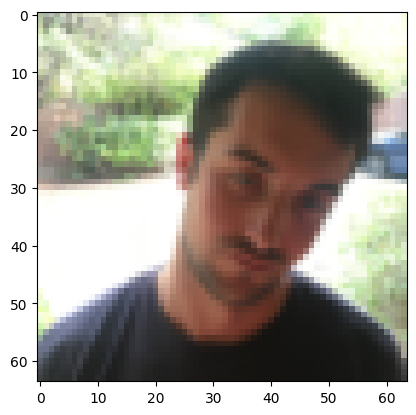

In [6]:
ph = X_train_orig[0]
ph = ph/255

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

plt.imshow(ph)
plt.show()

This guy doesn't look so happy. So our journey didn't actually start with a smile :( 

Now, let's prepare the dataset for out model.

In [7]:
type(X_train_orig)

h5py._hl.dataset.Dataset

In [8]:


# Convert to NumPy arrays
X_train_np = X_train_orig[:]
X_test_np = X_test_orig[:]
Y_train_np = Y_train_orig[:]
Y_test_np = Y_test_orig[:]


# Normalize the input features
X_train_np = X_train_np / 255.0
X_test_np = X_test_np / 255.0


# Reshape
Y_train = Y_train_orig[:].reshape(-1, 1)
Y_test = Y_test_orig[:].reshape(-1, 1)

print ("number of training examples = " + str(X_train_np.shape[0]))
print ("number of test examples = " + str(X_test_np.shape[0]))
print ("X_train shape: " + str(X_train_np.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test_np.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


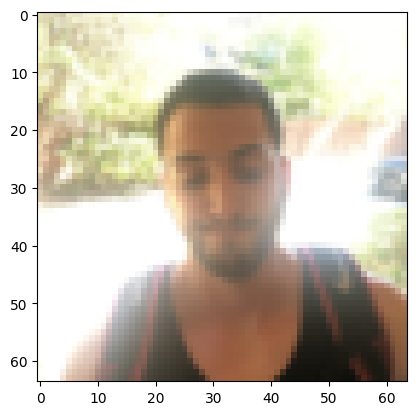

In [9]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

In [10]:
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

2025-08-08 13:40:45.079208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754660445.376626      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754660445.464654      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tfl.ZeroPadding2D(padding = 3, input_shape = (64, 64, 3)),
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1)),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPool2D(),
            ## Flatten layer
            tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(units = 1, activation='sigmoid')
            # YOUR CODE STARTS HERE
            
            
            # YOUR CODE ENDS HERE
        ])
    
    return model

In [12]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-08-08 13:41:02.285642: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'summary' is not defined

In [13]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [14]:
happy_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

In [16]:
happy_model.fit(X_train_np, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6910 - loss: 1.7494
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8882 - loss: 0.2903
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9475 - loss: 0.1471
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8898 - loss: 0.3056
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9670 - loss: 0.0769
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9586 - loss: 0.1120
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9621 - loss: 0.0789
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9762 - loss: 0.0818
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9490 - loss: 0.1454
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9583 - loss: 0.1137


In [17]:
happy_model.evaluate(X_test_np, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9497 - loss: 0.1336


[0.12775421142578125, 0.95333331823349]

94.97% accuracy.